In [5]:
import os
import torch
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as ipd

from data.dataset import MultitrackAudioDataset
from inference_utils import mix_song_smooth, load_tracks

%load_ext autoreload
%autoreload 2

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Device: ', device)

tracklist = ['bass', 'drums', 'vocals', 'other']
base_dir = '/media/apelykh/bottomless-pit/datasets/mixing/MedleyDB/Audio/'
song_name = 'SweetLights_YouLetMeDown'

loaded_tracks = load_tracks(base_dir, song_name)

Device:  cuda


In [8]:
d = MultitrackAudioDataset(
    base_dir,
    songlist=[],
    chunk_length=1,
    train_val_test_split=(0.0, 0.0, 1.0),
    mode='test',
    seed=321,
    normalize=False
)

### Naive mixing model 

In [4]:
from models.model_dummy import ModelDummy

In [5]:
model_dummy = ModelDummy().to(device)

In [14]:
per_track_features = []

for track in tracklist:
    features = d.compute_features(loaded_tracks[track][44100 * 30:44100 * 50])
    per_track_features.append(features)

feature_stack = np.stack(per_track_features)
feature_tensor = torch.from_numpy(feature_stack).unsqueeze(0)

masked = model_dummy(feature_tensor.to(device))

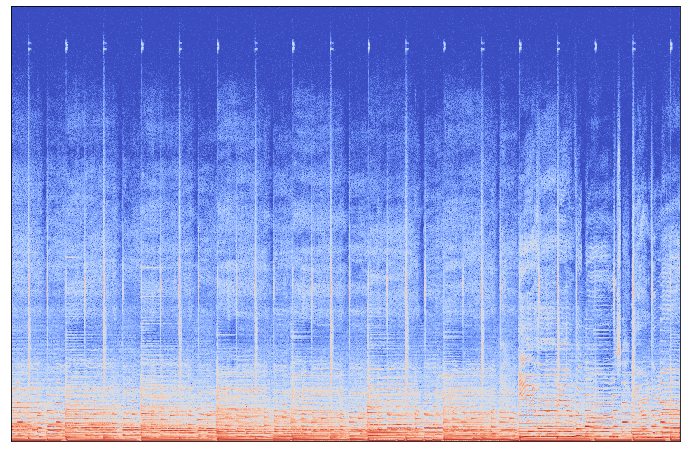

In [15]:
plt.figure(figsize=(12,8))
masked = masked[0].detach().cpu().numpy()
#!!
masked = librosa.util.normalize(masked)

librosa.display.specshow(masked)
plt.show()

In [16]:
print(np.min(masked), np.mean(masked), np.max(masked))

-1.0 -0.61009365 0.73039055


In [4]:
sum_track = np.zeros_like(loaded_tracks['bass'])

for track in tracklist:
    sum_track += loaded_tracks[track]

# sum_track = librosa.util.normalize(sum_track)
sum_features = d.compute_features(sum_track[44100 * 30:44100 * 50])

# !!!
sum_features = librosa.util.normalize(sum_features)

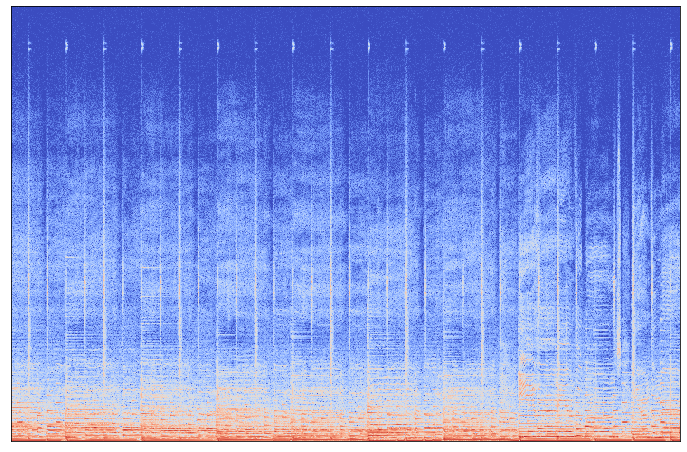

In [18]:
plt.figure(figsize=(12,8))
librosa.display.specshow(sum_features)
plt.show()

In [19]:
print(np.min(sum_features), np.mean(sum_features), np.max(sum_features))

-1.0 -0.6236855 0.81560236


In [20]:
mse = torch.nn.MSELoss()
smooth_L1 = torch.nn.SmoothL1Loss()

print(mse(torch.from_numpy(sum_features), torch.from_numpy(masked)))
print(smooth_L1(torch.from_numpy(sum_features), torch.from_numpy(masked)))

tensor(0.0035)
tensor(0.0017)


> MSE **0.0786** for normalized output specs wthout dB transforms

> MSE **0.0035** wth dB transforms (dB-ampl -> sum -> ampl-dB)

### Exploring data augmentation

In [3]:
base_dir = '/media/apelykh/bottomless-pit/datasets/mixing/MedleyDB/Audio/'
song_name = 'SweetLights_YouLetMeDown'

loaded_tracks = load_tracks(base_dir, song_name)

In [11]:
tracks = ['bass', 'drums', 'vocals', 'other']

gains = []
features_list = []

for i, track in enumerate(tracks):
    random_gain = np.random.uniform(0.8, 1.2)
    gains.append(random_gain)
    print('{} gain: {:.4f}'.format(track, random_gain))
    
    augm_audio = random_gain * loaded_tracks[track][:, 20*44100:35*44100]

    features = d.compute_features(augm_audio)
    features_list.append(features)

train_features = np.stack(features_list)

bass gain: 1.1248
drums gain: 1.1582
vocals gain: 1.0669
other gain: 0.8880


In [12]:
features_list = []

for i, track in enumerate(tracks):
    audio = loaded_tracks[track][:, 20*44100:35*44100]
    features = d.compute_features(audio)

    gain_db = 20 * np.log10(gains[i])
    print(gains[i], gain_db)

    augm_features = gain_db + features
    features_list.append(augm_features)
    
train_features2 = np.stack(features_list)

1.1247681425532579 1.0212601416148799
1.1582341641242428 1.2759274210959508
1.0669200591889223 0.5626376077256732
0.8880228628738536 -1.031517056226718


In [13]:
mse = torch.nn.MSELoss()
print(mse(torch.from_numpy(train_features), torch.from_numpy(train_features2)))

tensor(1.8107e-10)


> Gain augmentation can be applied at the spectrogram level but the gain values should be converted to dB and **added** to dB feature maps and not **multiplied** by them!

### Random gain augmentation on a sample level

In [ ]:
import IPython.display as ipd

base_dir = '/media/apelykh/bottomless-pit/datasets/mixing/MedleyDB/Audio/'
song_name = 'SweetLights_YouLetMeDown'

loaded_tracks = load_tracks(base_dir, song_name)

tracks = ['bass', 'drums', 'vocals', 'other']

sum_track = np.zeros_like(loaded_tracks['mix'])
for i, track in enumerate(tracks):
    random_gain = np.random.uniform(0.5, 1.5)
    print(random_gain)
    sum_track += random_gain * loaded_tracks[track]

sum_track = librosa.util.normalize(sum_track, axis=1)

ipd.Audio(sum_track, rate=44100)

---
### Reconstructing mixture audio from individual track spectrograms

In [1]:
import os
import IPython.display as ipd
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt

/home/apelykh/.virtualenvs/pytorch-audio/lib/python3.6/site-packages/librosa/util/decorators.py:9: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import of 'jit' requested from: 'numba.decorators', please update to use 'numba.core.decorators' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.decorators import jit as optional_jit


In [2]:
song_name = 'CelestialShore_DieForUs'
song_path = '/media/apelykh/bottomless-pit/datasets/mixing/MedleyDB/Audio/CelestialShore_DieForUs/'
tracklist = ['bass', 'drums', 'vocals', 'other', 'mix']
sr = 44100

loaded_tracks = {}

for track_name in tracklist:
    if track_name == 'mix':
        track_path = os.path.join(song_path, '{}_MIX.wav'.format(song_name))
    else:
        track_path = os.path.join(song_path, '{}_STEMS_JOINED'.format(song_name),
                                  '{}_STEM_{}.wav'.format(song_name, track_name.upper()))

    loaded_tracks[track_name], _ = librosa.load(track_path, sr=sr)

In [3]:
def compute_features(audio, window_size=2048, hop_length=512):
    window = np.hanning(window_size)

    spectrum = librosa.stft(audio, n_fft=window_size, hop_length=hop_length, window=window)
#     spectrum = 2 * np.abs(spectrum) / np.sum(window)
    magnitudes = np.abs(spectrum)

    # dtype=np.complex64
    phases = spectrum / magnitudes
    features = librosa.amplitude_to_db(magnitudes)

    return features, phases

In [19]:
features_list = []
phases_list = []
result = {}

for track_name in tracklist:
    audio_chunk = loaded_tracks[track_name][44100 * 53:44100 * 55]
    features, phases = compute_features(audio_chunk)

    if track_name == 'mix':
        result['gt_features'] = features
        result['gt_phases'] = phases
    else:
        features_list.append(features)
        phases_list.append(phases)

result['train_features'] = np.stack(features_list)
result['train_phases'] = np.stack(phases_list)

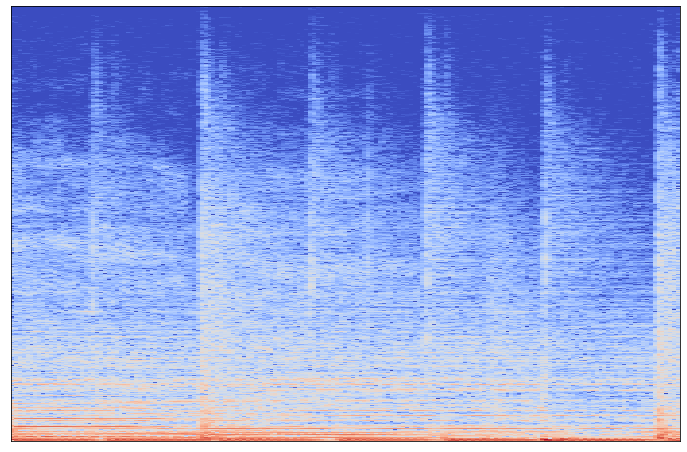

In [20]:
plt.figure(figsize=(12, 8))
librosa.display.specshow(result['gt_features'])
plt.show()

In [21]:
result['gt_features'].shape

(1025, 173)

In [5]:
mixed = np.max(result['train_features'], axis=0)

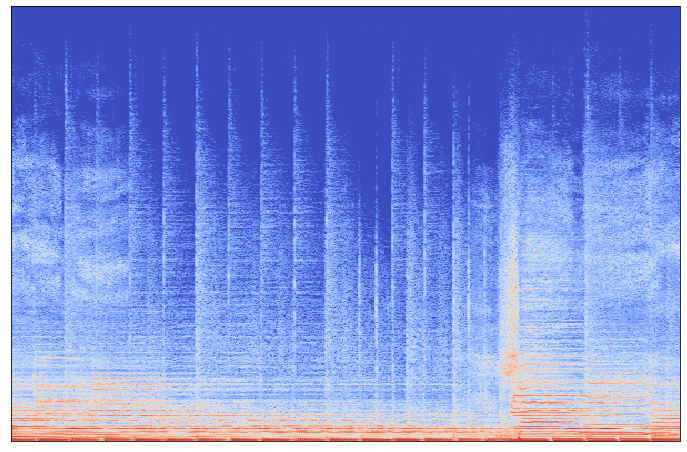

In [8]:
plt.figure(figsize=(12, 8))
librosa.display.specshow(mixed)
plt.show()

In [14]:
sum_audio, _ = librosa.load(os.path.join(song_path, '{}_SUM.wav'.format(song_name)), sr=sr)

sum_audio = sum_audio[44100 * 53:44100 * 60]
sum_features, sum_phases = compute_features(sum_audio)
ipd.Audio(sum_audio, rate=44100)

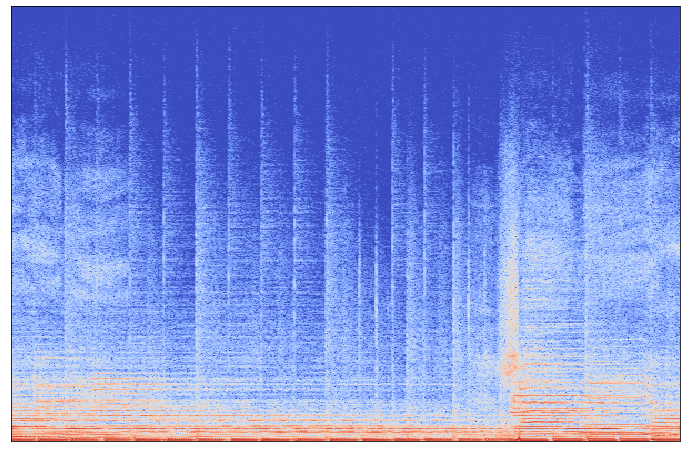

In [10]:
plt.figure(figsize=(12, 8))
librosa.display.specshow(sum_features)
plt.show()

In [7]:
print(np.min(mixed), np.max(mixed), np.mean(mixed))
print(np.min(sum_features), np.max(sum_features), np.mean(sum_features))

-43.866974 36.133026 -28.30116
-38.64468 41.35532 -23.125225


In [15]:
mixed = librosa.db_to_amplitude(mixed)

phases = sum_phases

restored_audio = librosa.core.istft(mixed * phases, win_length=2048, hop_length=512)
ipd.Audio(restored_audio, rate=sr)

### - Align Armand's MUSBD gain mixes with mixtures' length

In [ ]:
song_name = 'Bill Chudziak - Children Of No-one'
song_path = os.path.join('/media/apelykh/bottomless-pit/datasets/mixing/MedleyDB/Audio', song_name)
sr = 44100

mix_audio, _ = librosa.load(os.path.join(song_path, '{}_MIX.wav'.format(song_name)), sr=sr, mono=False)
mixture_audio, _ = librosa.load(os.path.join(song_path, '{}_MIXTURE.wav'.format(song_name)), sr=sr, mono=False)
print(mix_audio.shape)
print(mixture_audio.shape)

# cut extra
mix_audio_new = mix_audio[:, :len(mixture_audio[0])]

# append 0s
# mix_audio_new = np.zeros_like(mixture_audio)
# mix_audio_new[:, :len(mix_audio[0])] = mix_audio
print(mix_audio_new.shape)

sf.write(os.path.join(song_path, '{}_MIX2.wav'.format(song_name)), mix_audio_new.T, 44100)